In [21]:
# Core data and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for ML and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.utils import resample

# Set visual style and random seed for reproducibility
sns.set(style="whitegrid", palette="muted")
RANDOM_STATE = 42

In [22]:
# make sure your CSV file is uploaded before running this cell
path = "diabetes_binary_classification_data.csv"
df = pd.read_csv(path)

print("Shape of dataset:", df.shape)
display(df.head())

Shape of dataset: (253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Total missing values: 0


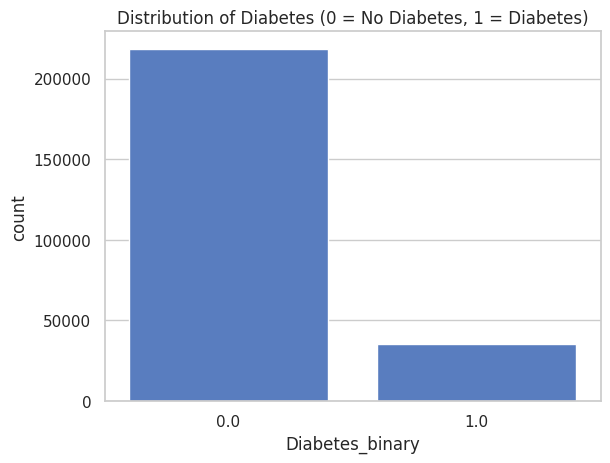

In [23]:
# Check for missing values
print("Total missing values:", df.isnull().sum().sum())

# Check class balance (important for diabetes prediction)
sns.countplot(x="Diabetes_binary", data=df)
plt.title("Distribution of Diabetes (0 = No Diabetes, 1 = Diabetes)")
plt.show()

# Create a clean binary target column
# 1 means the person has diabetes, 0 means they do not
df['diabetes'] = (df['Diabetes_binary'] == 1).astype(int)

# Drop the original column to avoid confusion
df.drop(columns=['Diabetes_binary'], inplace=True)

In [24]:
# Some continuous features (like BMI or days of poor health) can be right-skewed.
# Applying a log-transform helps make their distribution more normal, which helps
# models like Logistic Regression perform better.
for col in ['BMI', 'MentHlth', 'PhysHlth']:
    if col in df.columns:
        df[col] = np.log1p(df[col])

# Check correlation between each feature and the target variable
corr = df.corr()['diabetes'].sort_values(ascending=False)
print("Top 10 correlations with diabetes:\n", corr.head(10))

Top 10 correlations with diabetes:
 diabetes                1.000000
GenHlth                 0.293569
HighBP                  0.263129
BMI                     0.225764
DiffWalk                0.218344
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.172748
Stroke                  0.105816
Name: diabetes, dtype: float64


In [25]:
# Separate features (X) and target (y)
X = df.drop(columns=['diabetes'])
y = df['diabetes']

# Use a STRATIFIED split — this ensures both train and test sets
# have the same proportion of diabetic vs non-diabetic cases.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))

Train set size: (202944, 21)
Test set size: (50736, 21)

Train class distribution:
 diabetes
0    0.860666
1    0.139334
Name: proportion, dtype: float64


In [26]:
# Standardize continuous features to mean=0, std=1 for better performance
# in models sensitive to scale (e.g., Logistic Regression).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Define helper function for evaluation in next cell

def evaluate_model(name, model, Xtr, Xte, ytr, yte):

    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)

    # For ROC curves we need probabilities (or decision scores)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(Xte)[:, 1]
    else:
        y_proba = model.decision_function(Xte)

    # Calculate evaluation metrics
    cm = confusion_matrix(yte, y_pred)
    report = classification_report(yte, y_pred, digits=4)
    fpr, tpr, _ = roc_curve(yte, y_proba)
    roc_auc = auc(fpr, tpr)

    # Display results
    print(f"--- {name} ---")
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", report)
    print(f"ROC AUC: {roc_auc:.4f}\n")

    return {'name': name, 'model': model, 'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

In [28]:
# We test 3 different models:
# 1. Logistic Regression
# 2. Random Forest
# 3. Gradient Boosting

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')
gb = GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)

# Store results for later comparison
results = []
results.append(evaluate_model("Logistic Regression", lr, X_train_scaled, X_test_scaled, y_train, y_test))
results.append(evaluate_model("Random Forest", rf, X_train, X_test, y_train, y_test))
results.append(evaluate_model("Gradient Boosting", gb, X_train, X_test, y_train, y_test))

--- Logistic Regression ---
Confusion matrix:
 [[31737 11930]
 [ 1667  5402]]

Classification report:
               precision    recall  f1-score   support

           0     0.9501    0.7268    0.8236     43667
           1     0.3117    0.7642    0.4428      7069

    accuracy                         0.7320     50736
   macro avg     0.6309    0.7455    0.6332     50736
weighted avg     0.8611    0.7320    0.7705     50736

ROC AUC: 0.8210

--- Random Forest ---
Confusion matrix:
 [[42370  1297]
 [ 5973  1096]]

Classification report:
               precision    recall  f1-score   support

           0     0.8764    0.9703    0.9210     43667
           1     0.4580    0.1550    0.2317      7069

    accuracy                         0.8567     50736
   macro avg     0.6672    0.5627    0.5763     50736
weighted avg     0.8181    0.8567    0.8249     50736

ROC AUC: 0.7951

--- Gradient Boosting ---
Confusion matrix:
 [[42666  1001]
 [ 5834  1235]]

Classification report:
            

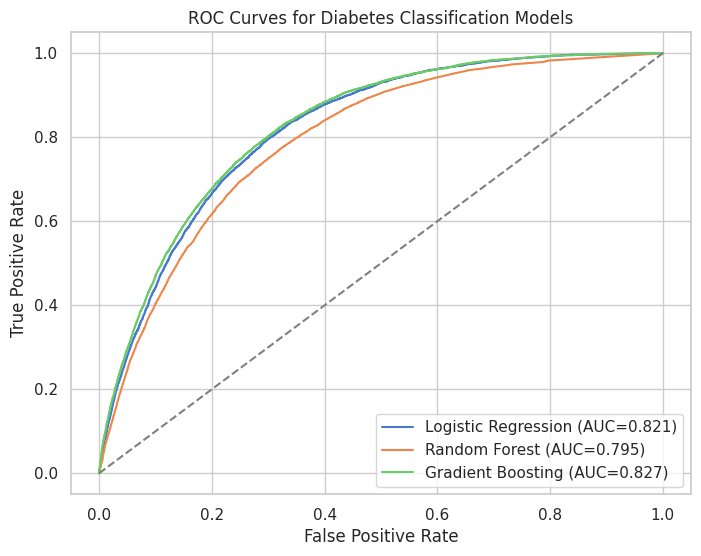

In [29]:
# Plot ROC curves for all models

plt.figure(figsize=(8,6))
for res in results:
    plt.plot(res['fpr'], res['tpr'], label=f"{res['name']} (AUC={res['auc']:.3f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curves for Diabetes Classification Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()